# Exploratory Data Analysis

In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)
    
# matplotlib and seaborn for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 250 #resolution
matplotlib.rcParams['figure.figsize'] = (8,6) #figure size

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
color = sns.color_palette()

from utils import *

#Data file directory
root = 'C:/Users/ALEXANDER/Documents/Machine Learning/Instacart/Data/'

In [2]:
#Read datasets
aisles = read(root,path='aisles')
departments = read(root,path='departments')
orders = read(root,path='orders')
order_products_prior = read(root,path='order_products__prior')
order_products_train = read(root,path='order_products__train')
products = read(root,path="products")

To make analysis easier, I will combine order_products_train and order_products_prior into a new dataset. I will also merged the newly created dataset with the metadata using `order_id`, `product_id`, `aisle_id` and `department_id` as keys. Thus creating a single dataframe.

In [3]:
combined_order = pd.concat([order_products_prior,order_products_train],0)
combined_order.shape

(33819106, 4)

In [4]:
combined_order = combined_order.merge(products, on ='product_id', how='left')
combined_order = combined_order.merge(aisles, on ='aisle_id', how='left')
combined_order = combined_order.merge(departments, on ='department_id', how='left')
combined_order = combined_order.merge(orders, on='order_id', how='left')
combined_order.shape

(33819106, 15)

In [5]:
#Preview combined data
combined_order.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [6]:
combined_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


### Optimizating Memory Usage
**Reduce memory usage**: Due to the size of the dataset, there is a need to reduce memory allocation in order to speed up analysis and aggregation. In `utils.py`, I have implemented a memory reduction function. 
I will also delete variables that are no longer useful to free up more memory!

In [7]:
combined_order = reduce_memory(combined_order)

Memory usage of properties dataframe is : 4128.308837890625  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  2031.902006149292  MB
This is  49.21875 % of the initial size


In [8]:
# Delete variables that are not needed anymore.
del products, orders, order_products_prior, order_products_train, aisles, departments, reduce_memory, root
%whos

Variable         Type             Data/Info
-------------------------------------------
bar_visual       function         <function bar_visual at 0x000001402E9ED160>
color            _ColorPalette    [(0.12156862745098039, 0.<...>863, 0.8117647058823529)]
combined_order   DataFrame                  order_id  produ<...>819106 rows x 15 columns]
count_viz        function         <function count_viz at 0x000001402E9ED1F0>
gc               module           <module 'gc' (built-in)>
matplotlib       module           <module 'matplotlib' from<...>matplotlib\\__init__.py'>
np               module           <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
os               module           <module 'os' from 'C:\\Us<...>\\anaconda3\\lib\\os.py'>
overlapped_bar   function         <function overlapped_bar at 0x000001402E9ED3A0>
pd               module           <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt              module           <module 'matplotlib.pyplo<...>\\matplotlib

## Reorder Analysis by Aisle
**An aisle is a long narrow gap that people can walk along between rows of shelves in a supermarket.**

In [9]:
total_df = combined_order.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
total_df = total_df.sort_values('total', ascending=False).reset_index()

Here, I have counted the sum of reordered items in an aisle/shelf. I will be analyzing the aisles with the most reorder rate. i.e. aisles which customers revisit to buy products.

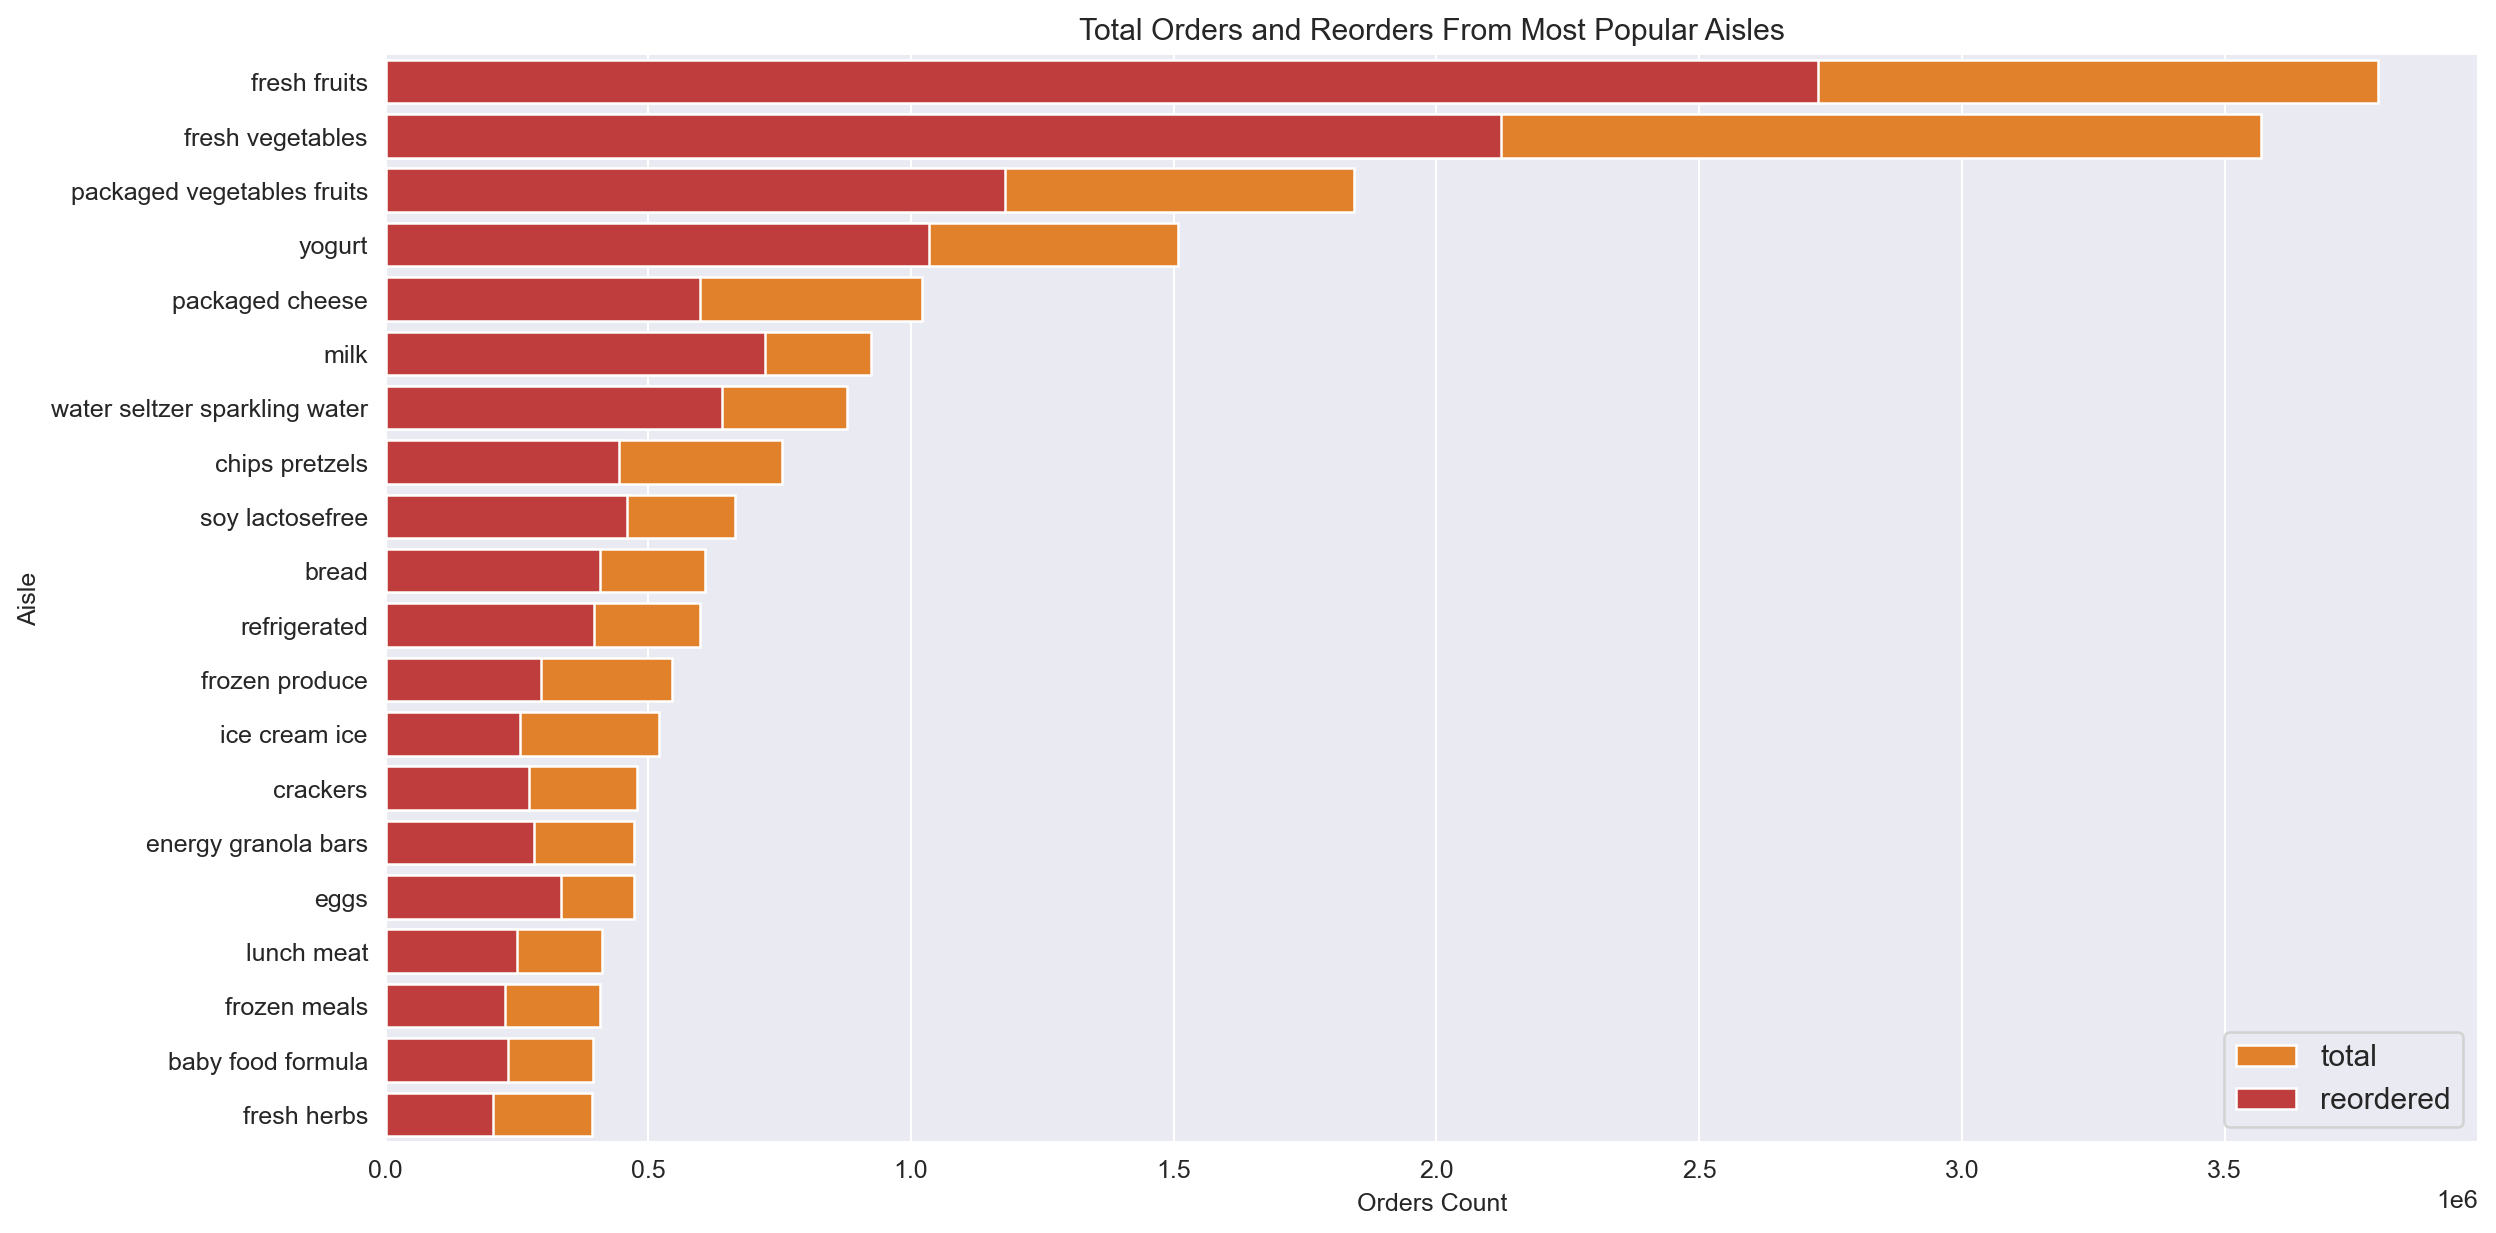

In [10]:
#Visualization of top 20 aisles whose products were reordered by customers
overlapped_bar(y_df=total_df['aisle'][0:20],x1_df=total_df['total'][0:20],
               x2_df= total_df['reorders'][0:20], xlabel="Orders Count",
               ylabel="Aisle",title="Total Orders and Reorders From Most Popular Aisles")

In [11]:
#Top 10 products with highest reorder ratio
total_df["ratio_of_reorder"] = total_df['reorders']/total_df['total']
sorted_reorder_aisle = total_df.sort_values("ratio_of_reorder", ascending=False)
sorted_reorder_aisle.head(10)

,aisle,total,reorders,ratio_of_reorder
5,milk,923659,722128.0,0.781812
6,water seltzer sparkling water,878150,640988.0,0.729930
0,fresh fruits,3792661,2726251.0,0.718823
15,eggs,472009,333408.0,0.706359
8,soy lactosefree,664493,460069.0,0.692361
33,packaged produce,289488,200319.0,0.691977
3,yogurt,1507583,1034957.0,0.686501
26,cream,330358,226356.0,0.685184
9,bread,608469,408010.0,0.670552
10,refrigerated,599109,397213.0,0.663006


- Majority of the aisles with high reorder rates contains diary products,vegetables and liquid drinks.


Let's visualize the top 20 Aisles with the highest reorder ratio

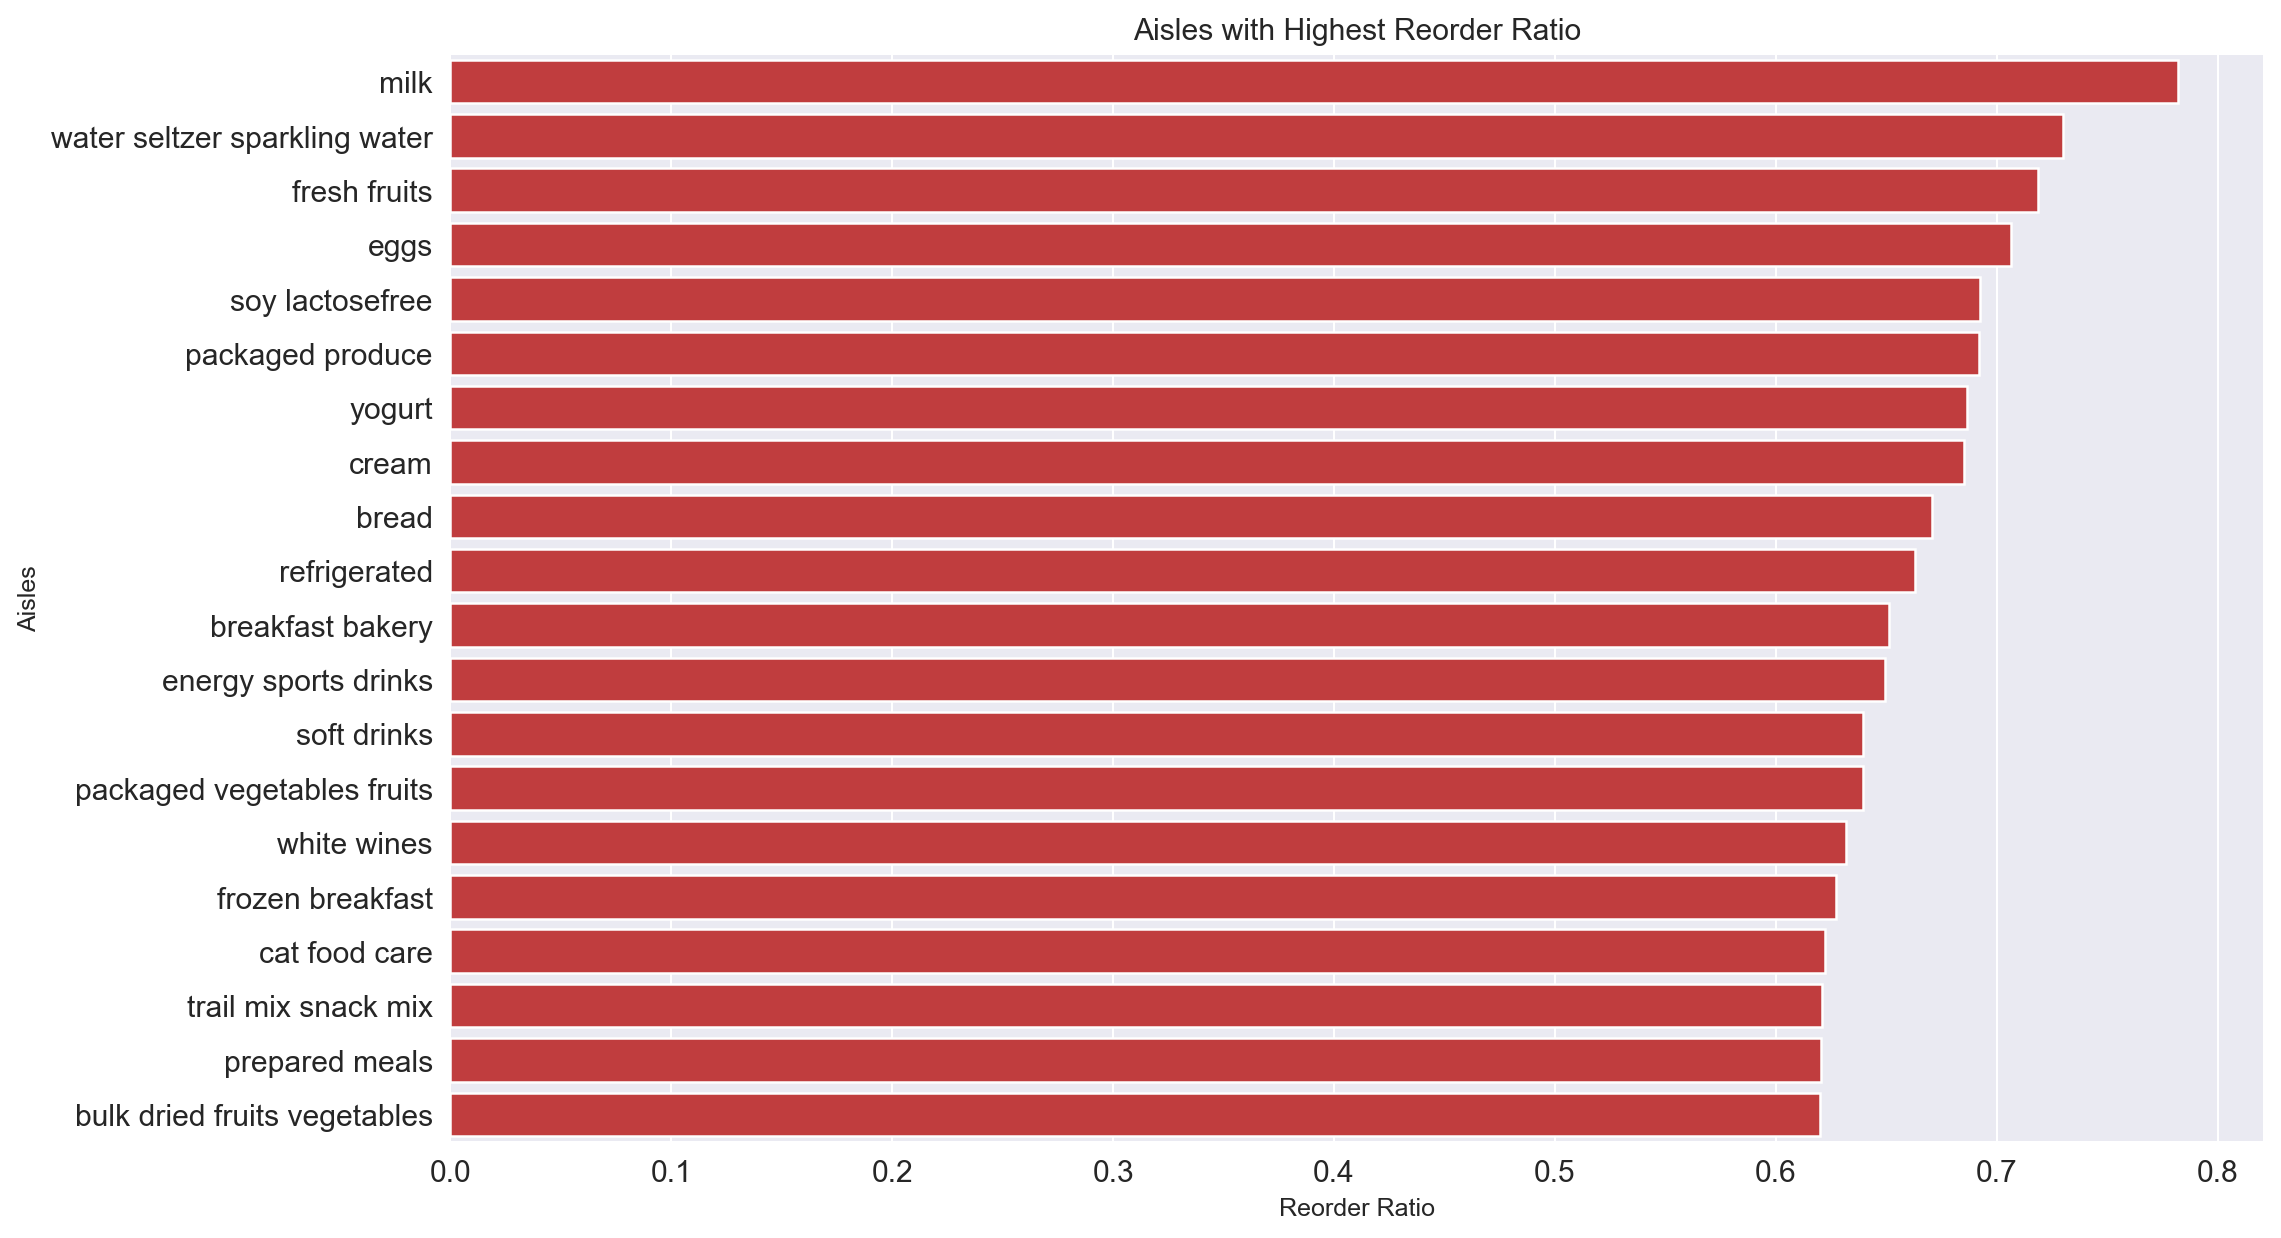

In [12]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = sorted_reorder_aisle['aisle'][:20], x = sorted_reorder_aisle['ratio_of_reorder'][:20], color=color[3])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

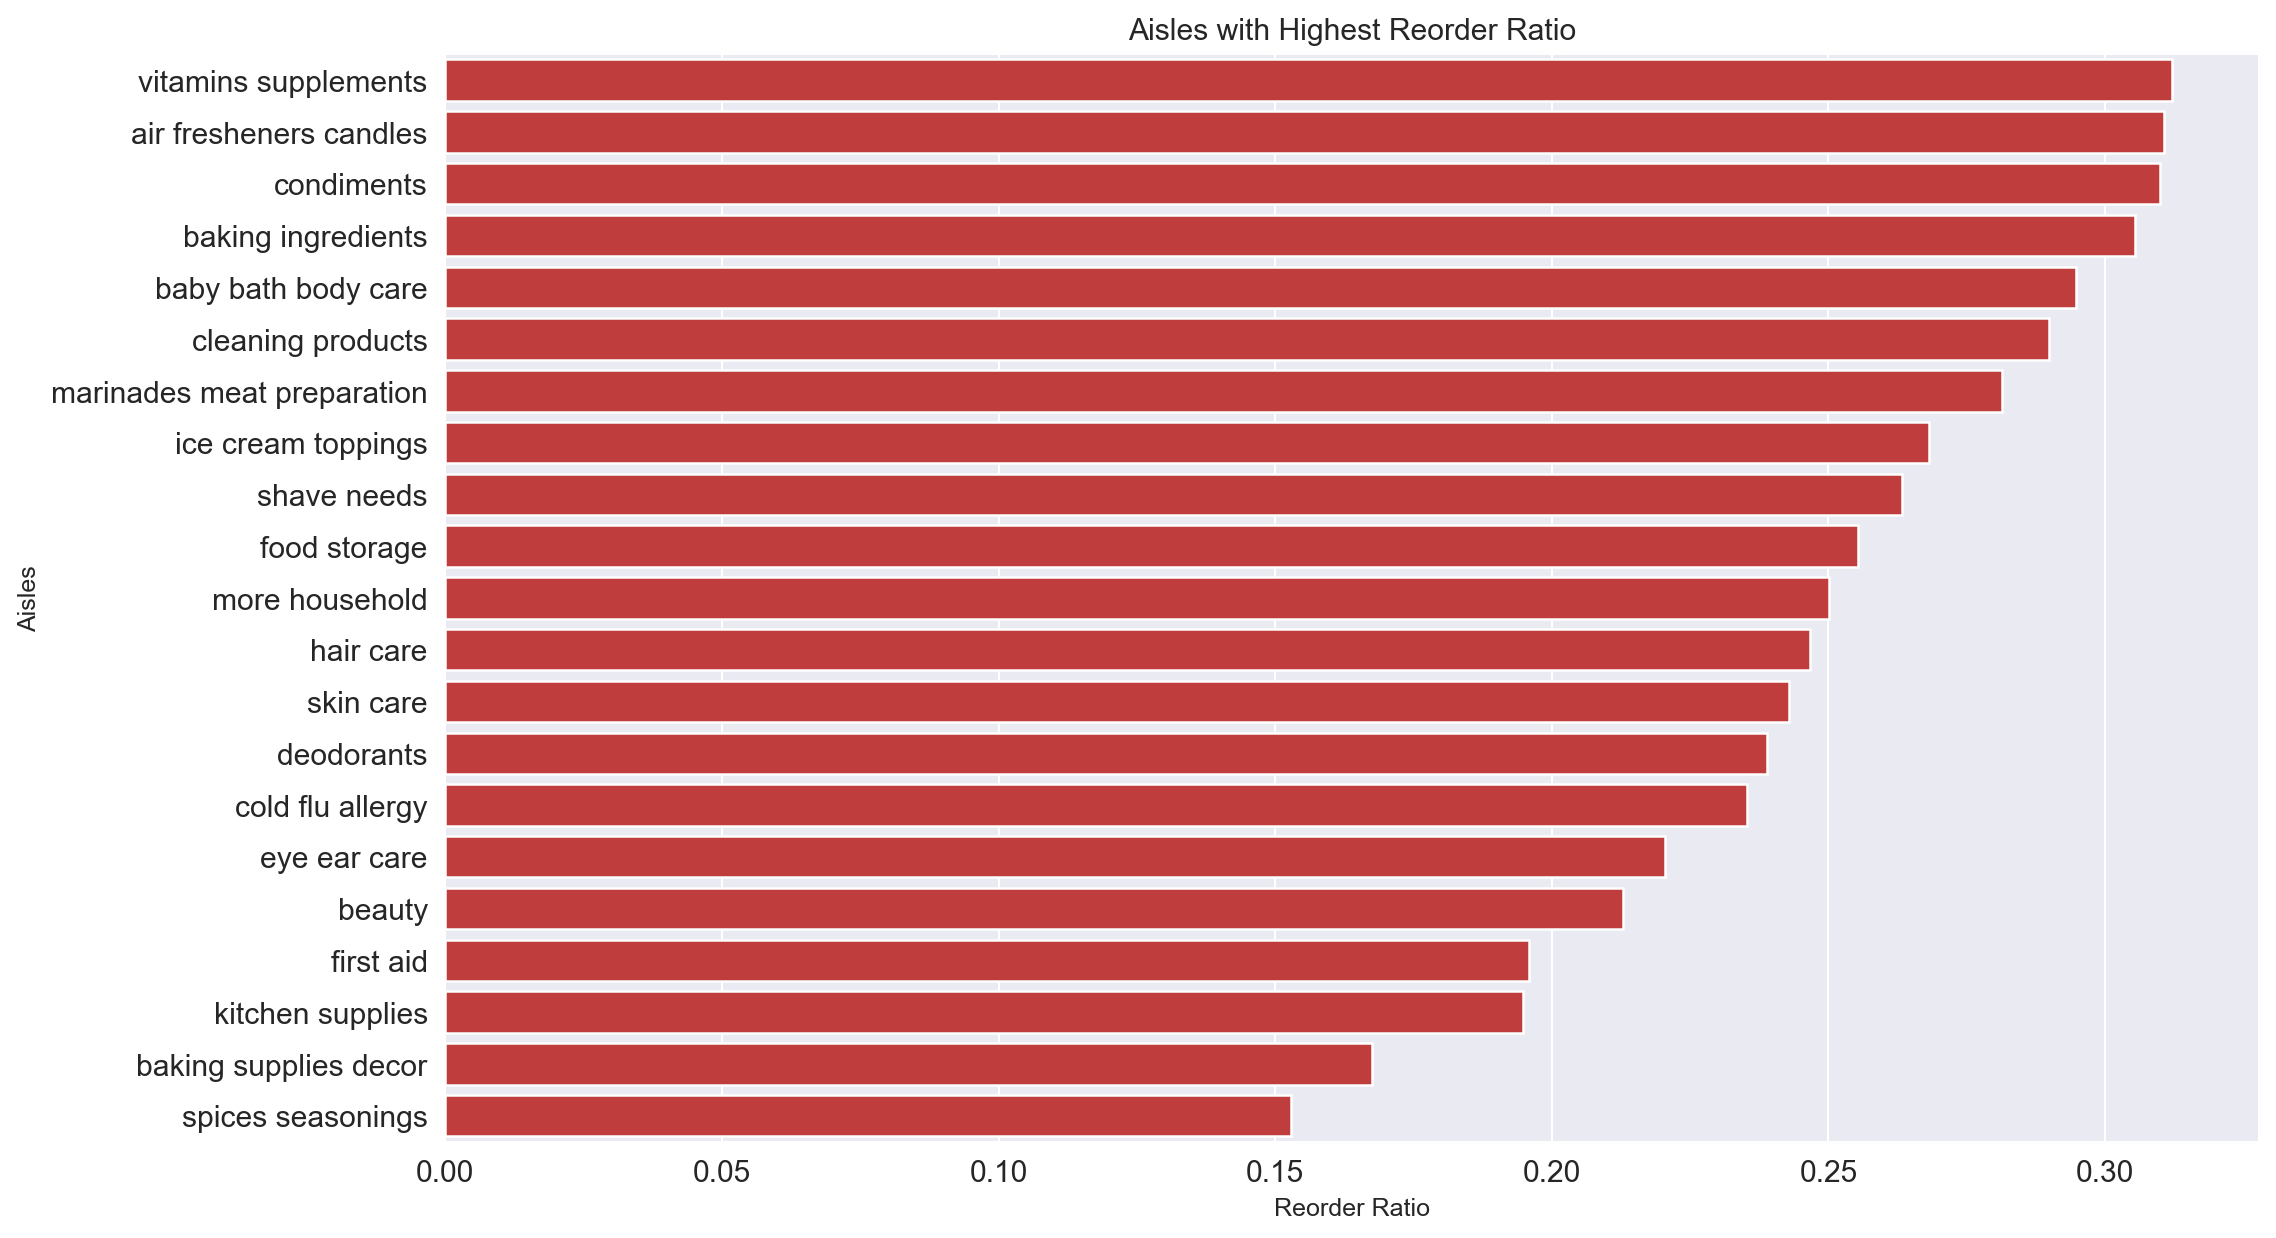

In [13]:
#Bottom 20 aisles with lowest reorder ratio
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = sorted_reorder_aisle['aisle'][-21:], x = sorted_reorder_aisle['ratio_of_reorder'][-21:], color=color[3])
ax.set_ylabel("Aisles")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Aisles with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

Aisles/shelves containing kitchen spices, beauty products and household supplies had the least reorder rate. This is because most of this products take a long time to consume or finish.

## Reorder Analysis by Departments

A department represents a section in a grocery store that is dedicated to specific kinds of products e.g `household` sections for household items and `frozen` section for frozen food and seafood.

In [14]:
total_df = combined_order.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
total_df = total_df.sort_values('total', ascending=False).reset_index()

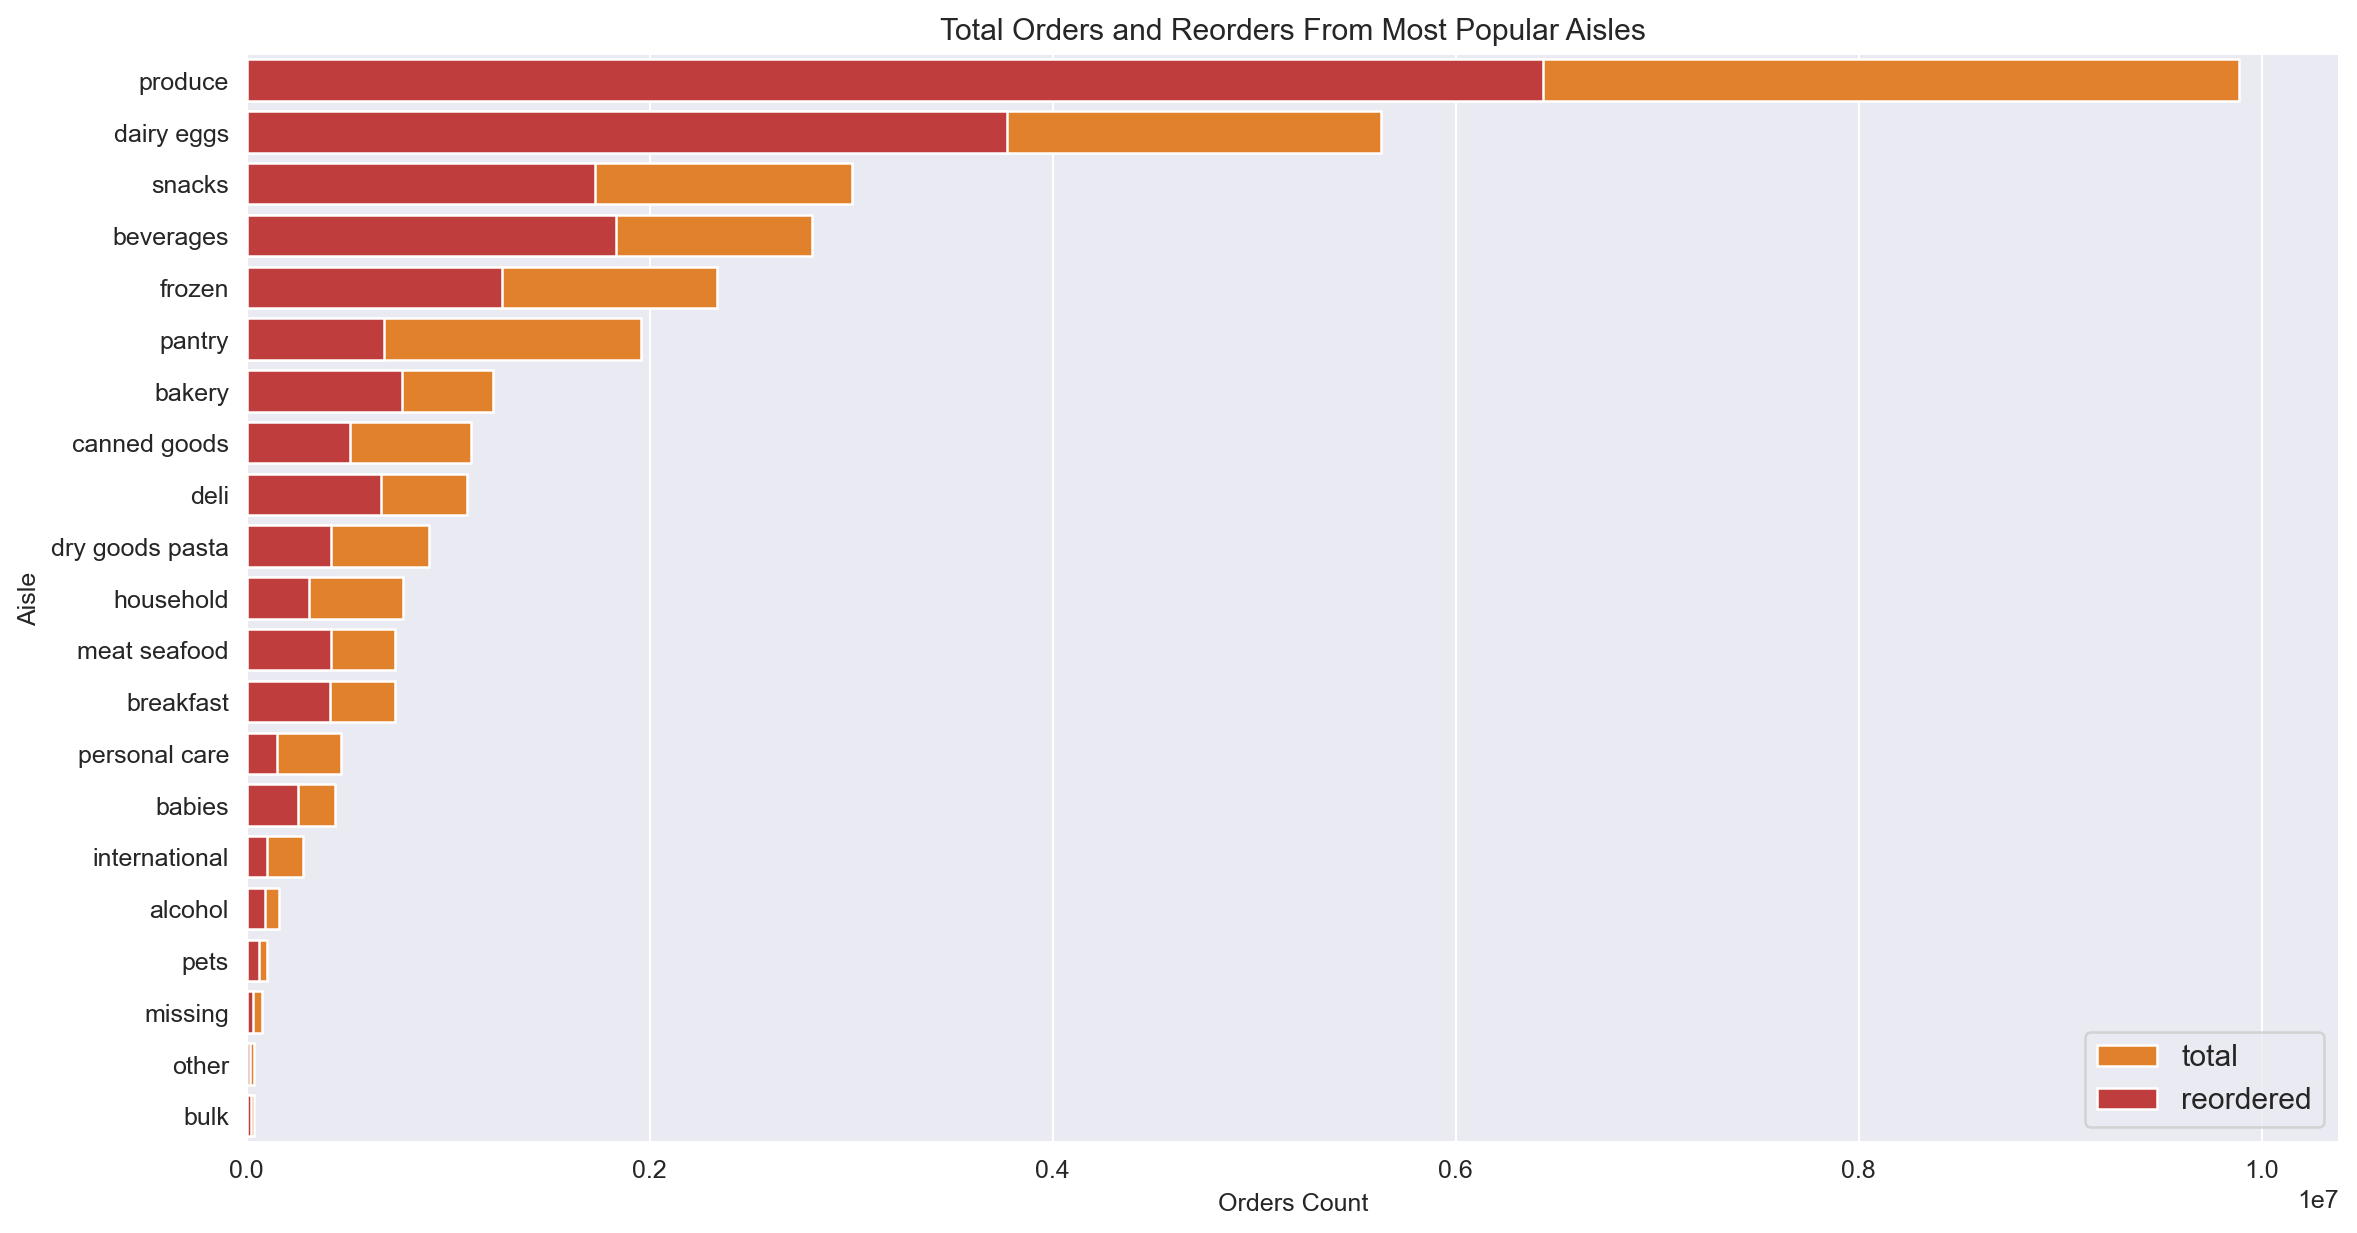

In [15]:
#Visualize top departments in grocery store with most reorder
overlapped_bar(y_df=total_df['department'],x1_df=total_df['total'],
               x2_df= total_df['reorders'], xlabel="Orders Count",
               ylabel="Department",title="Total Orders and Reorders From Departments")

In [16]:
#Top 10 products with highest reorder ratio
total_df["ratio_of_reorder"] = total_df['reorders']/total_df['total']
sorted_reorder_dept = total_df.sort_values("ratio_of_reorder", ascending=False).reset_index(drop=True)
sorted_reorder_dept.head(10)

,department,total,reorders,ratio_of_reorder
0,dairy eggs,5631067,3773723.0,0.670161
1,beverages,2804175,1832952.0,0.653651
2,produce,9888378,6432596.0,0.650521
3,bakery,1225181,769880.0,0.628381
4,deli,1095540,666231.0,0.608130
5,pets,102221,61594.0,0.602557
6,babies,438743,253453.0,0.577680
7,bulk,35932,20736.0,0.577090
8,snacks,3006412,1727075.0,0.574464
9,alcohol,159294,90992.0,0.571221


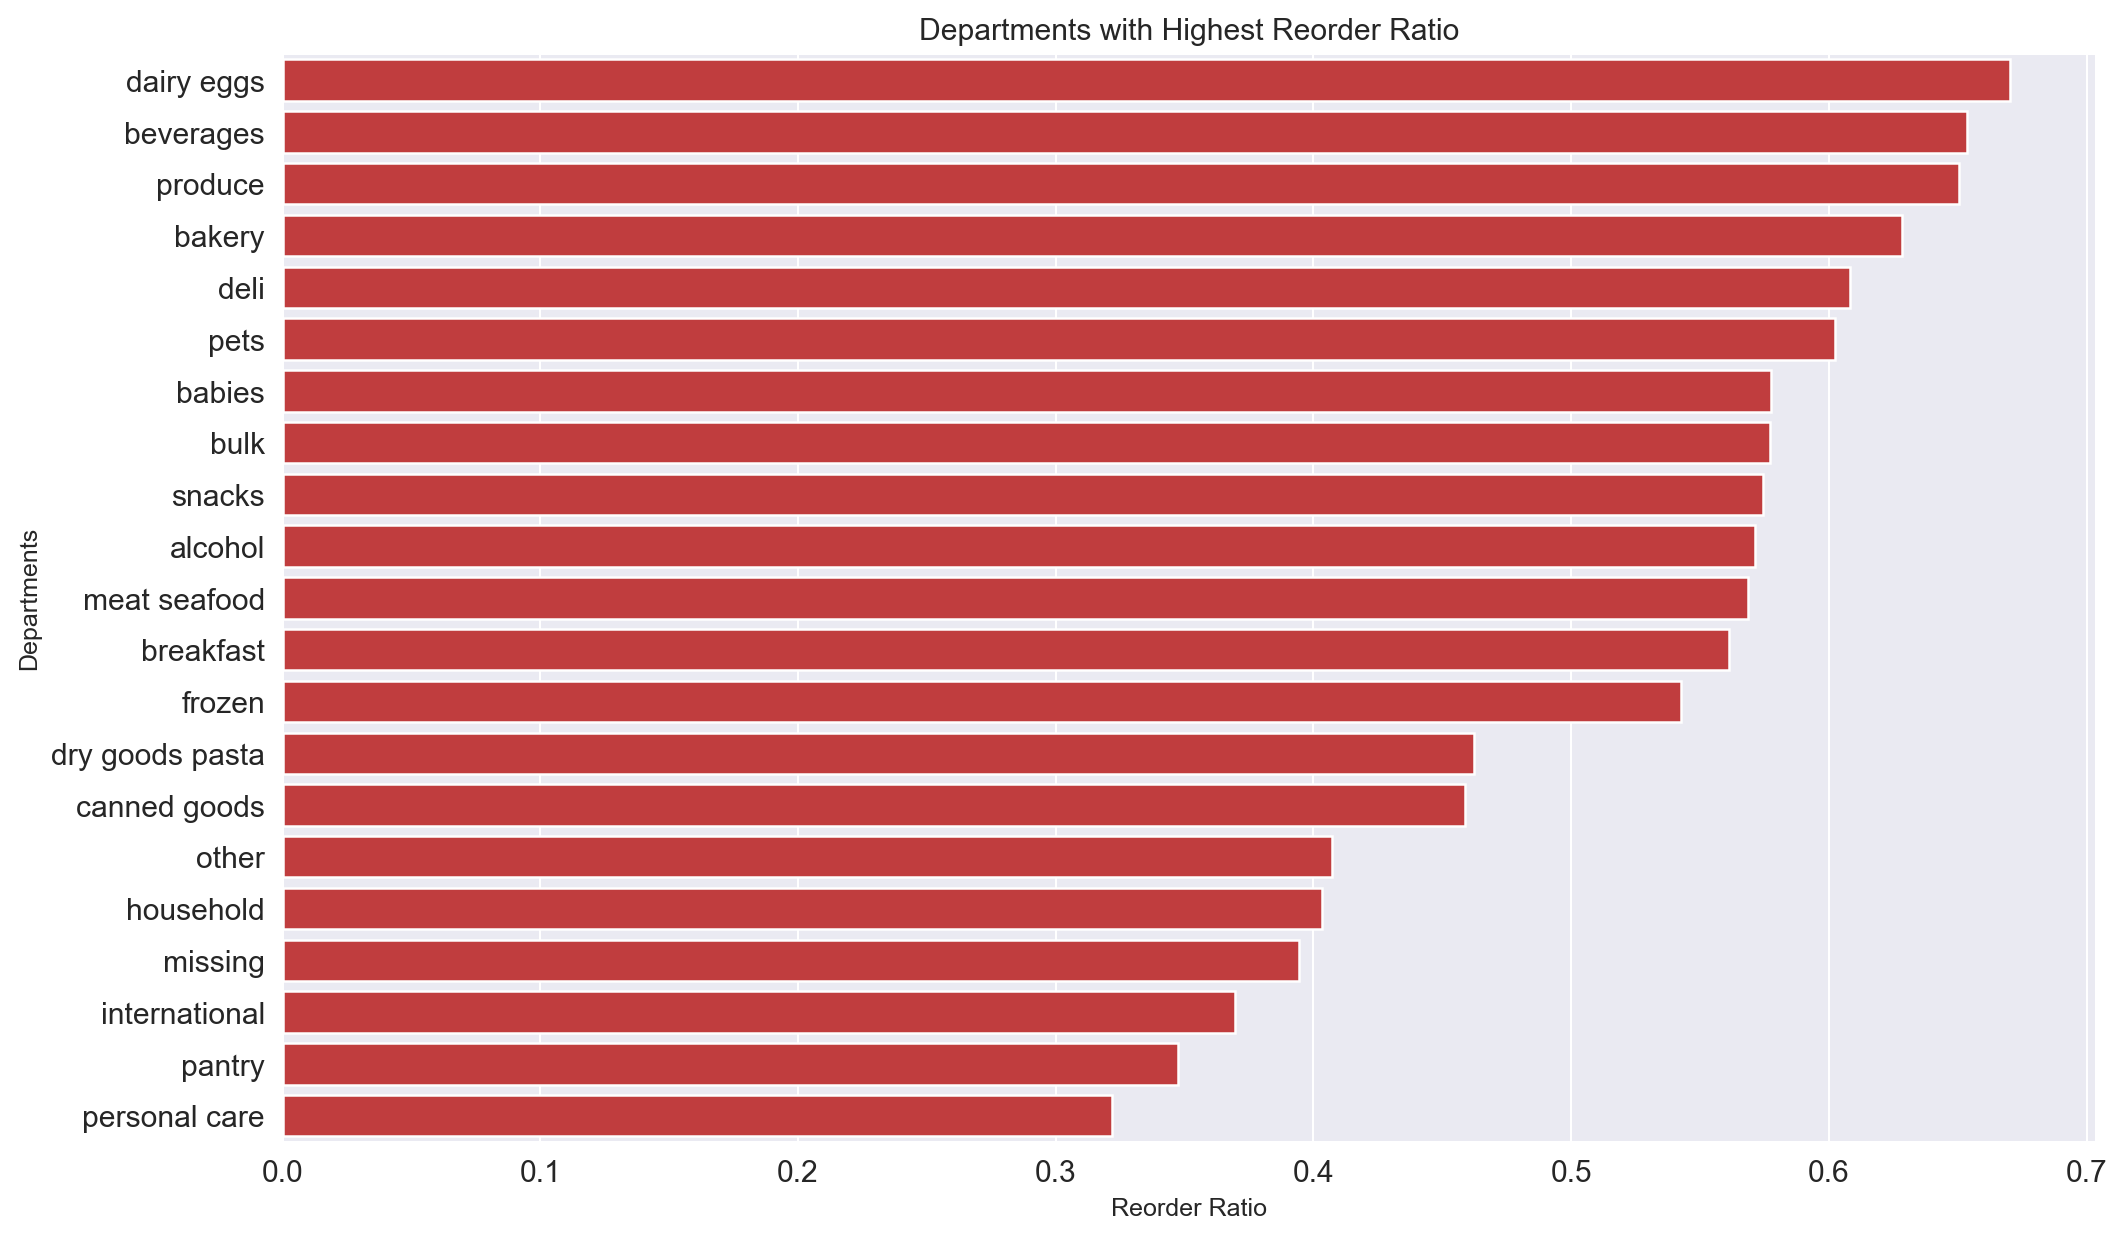

In [17]:
fig, ax = plt.subplots(figsize = (13,8))
ax = sns.barplot(y = sorted_reorder_dept['department'], x = sorted_reorder_dept['ratio_of_reorder'], color=color[3])
ax.set_ylabel("Departments")
ax.set_xlabel("Reorder Ratio")
ax.set_title("Departments with Highest Reorder Ratio")
ax.tick_params(axis = 'both', labelsize = 12)
plt.show()

## Reorder Analysis by Products

- Which class of products had the most reorder within a given time frame??

In [18]:
total_df = combined_order.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
total_df = total_df.sort_values("total", ascending=False).reset_index()

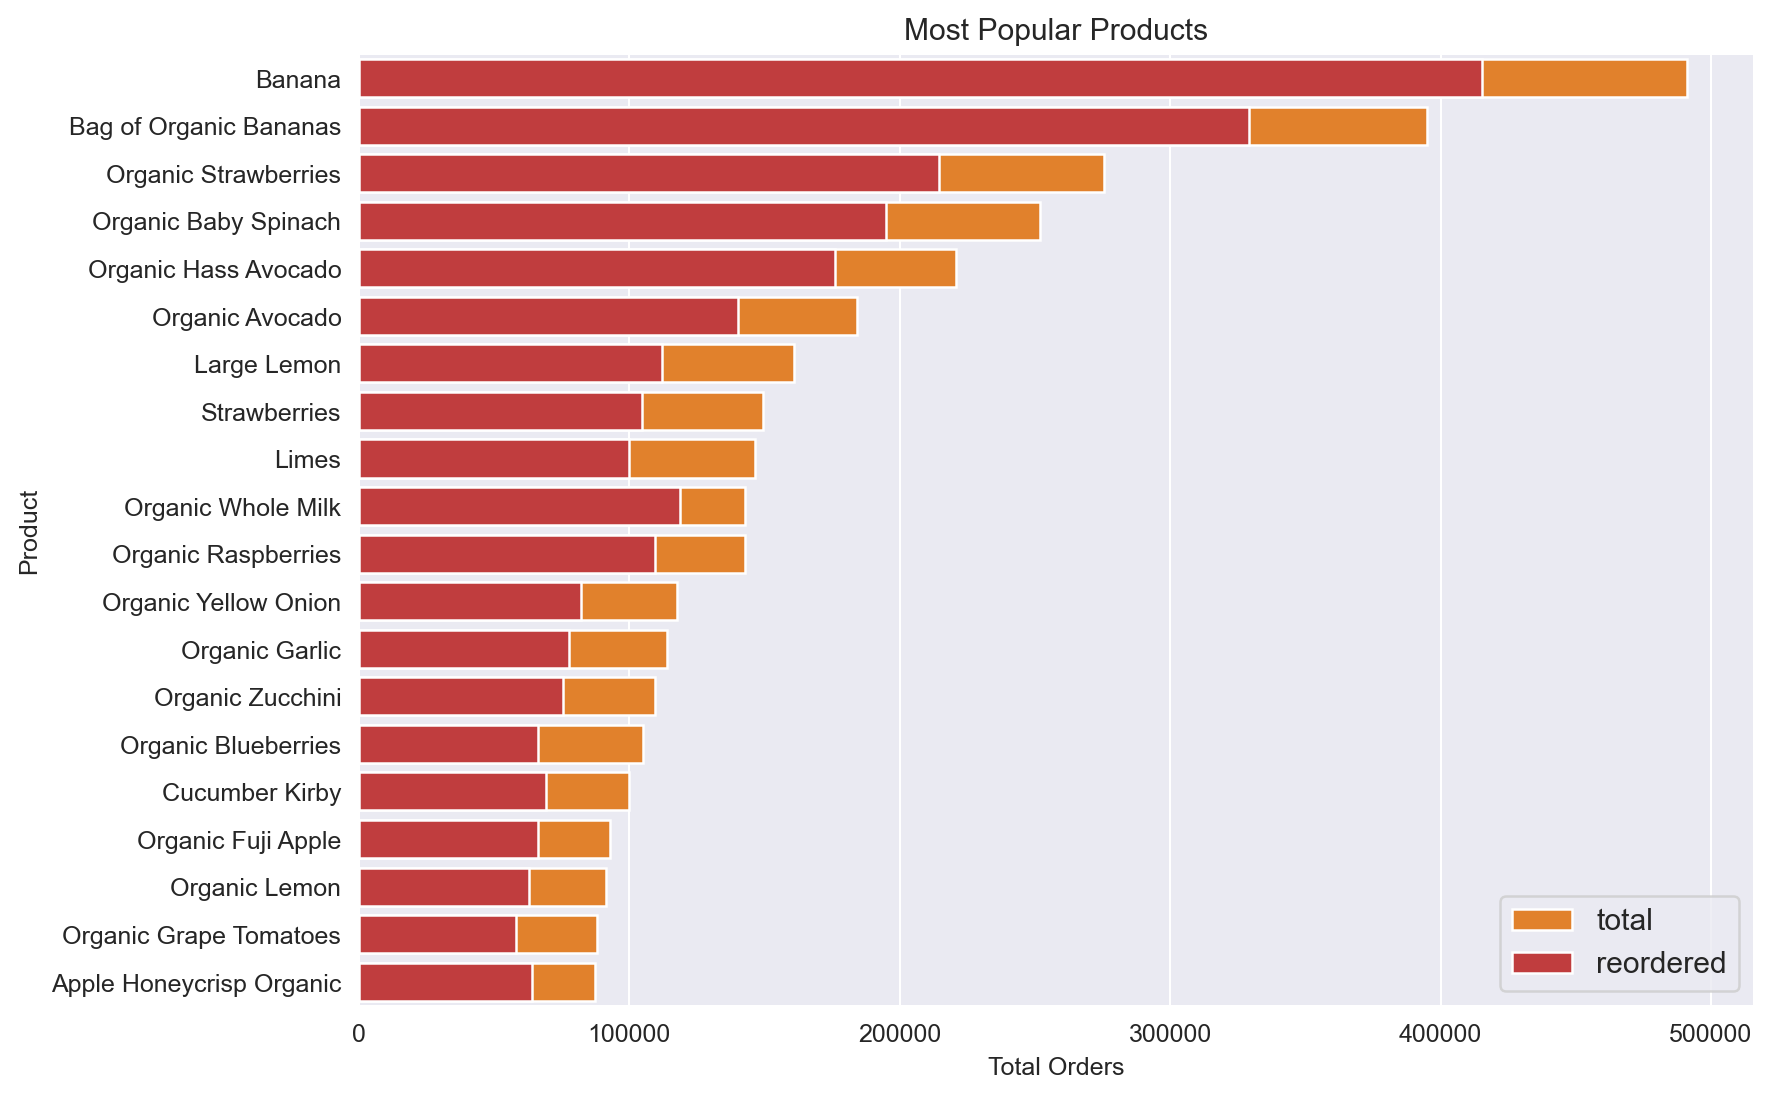

In [19]:
fig, ax = plt.subplots(figsize = (10,7))
ax = sns.barplot(y = total_df['product_name'][:20], x = total_df['total'][:20], color=color[1], label = "total")
ax = sns.barplot(y = total_df['product_name'][:20], x = total_df['reorders'][:20], color=color[3], label = "reordered")
ax.set_ylabel("Product")
ax.set_xlabel("Total Orders")
ax.set_title("Most Popular Products")
ax.legend(loc = 4, prop={'size': 12})
plt.show()

In [20]:
#Top 10 products with highest reorder ratio
total_df["ratio_of_reorder"] = total_df['reorders']/total_df['total']
total_df.sort_values("ratio_of_reorder", ascending=False).head(10)

,product_name,total,reorders,ratio_of_reorder
23853,Raw Veggie Wrappers,69,65.0,0.942029
21388,Serenity Ultimate Extrema Overnight Pads,90,84.0,0.933333
40147,Orange Energy Shots,13,12.0,0.923077
20296,Chocolate Love Bar,102,94.0,0.921569
30746,Soy Powder Infant Formula,35,32.0,0.914286
28078,Simply Sleep Nighttime Sleep Aid,45,41.0,0.911111
35213,"Energy Shot, Grape Flavor",22,20.0,0.909091
32316,Russian River Valley Reserve Pinot Noir,30,27.0,0.900000
23918,Bars Peanut Butter,69,62.0,0.898551
24218,Soy Crisps Lightly Salted,67,60.0,0.895522


- Product with short consumption lifespan had the highest reorder rate. 
    - For instance overnight pads and sleeping aid are diposable after use. Hence the explained reorder rate.
    - Snacks such as Energy shots, chocolate and utilty items such as vegetable wrapper have high reorder rates.

Let's have a look at the number of customers who buy the products with the highest reorder ratio.

In [21]:
# No of customers who ordered top products with high reorder ratio.
unique_product_users = combined_order.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id':'total_users'})
unique_product_users.sort_values('total_users', ascending = False).head(10)

,product_name,total_users
3677,Banana,76125
3472,Bag of Organic Bananas,65655
31923,Organic Strawberries,61129
28843,Organic Baby Spinach,56766
22415,Large Lemon,48614
23422,Limes,46658
42908,Strawberries,44857
30300,Organic Hass Avocado,44704
28807,Organic Avocado,43954
29011,Organic Blueberries,38720


In [22]:
unique_product_users = unique_product_users.merge(total_df, on='product_name', how='left')
unique_product_users.sort_values("ratio_of_reorder", ascending=False).head(10)

,product_name,total_users,total,reorders,ratio_of_reorder
37379,Raw Veggie Wrappers,4,69,65.0,0.942029
39870,Serenity Ultimate Extrema Overnight Pads,6,90,84.0,0.933333
28415,Orange Energy Shots,1,13,12.0,0.923077
8537,Chocolate Love Bar,8,102,94.0,0.921569
41723,Soy Powder Infant Formula,3,35,32.0,0.914286
40458,Simply Sleep Nighttime Sleep Aid,4,45,41.0,0.911111
13844,"Energy Shot, Grape Flavor",2,22,20.0,0.909091
38793,Russian River Valley Reserve Pinot Noir,3,30,27.0,0.900000
3832,Bars Peanut Butter,7,69,62.0,0.898551
41712,Soy Crisps Lightly Salted,7,67,60.0,0.895522


#### Total Product Orders VS Total Unique Product Buyers

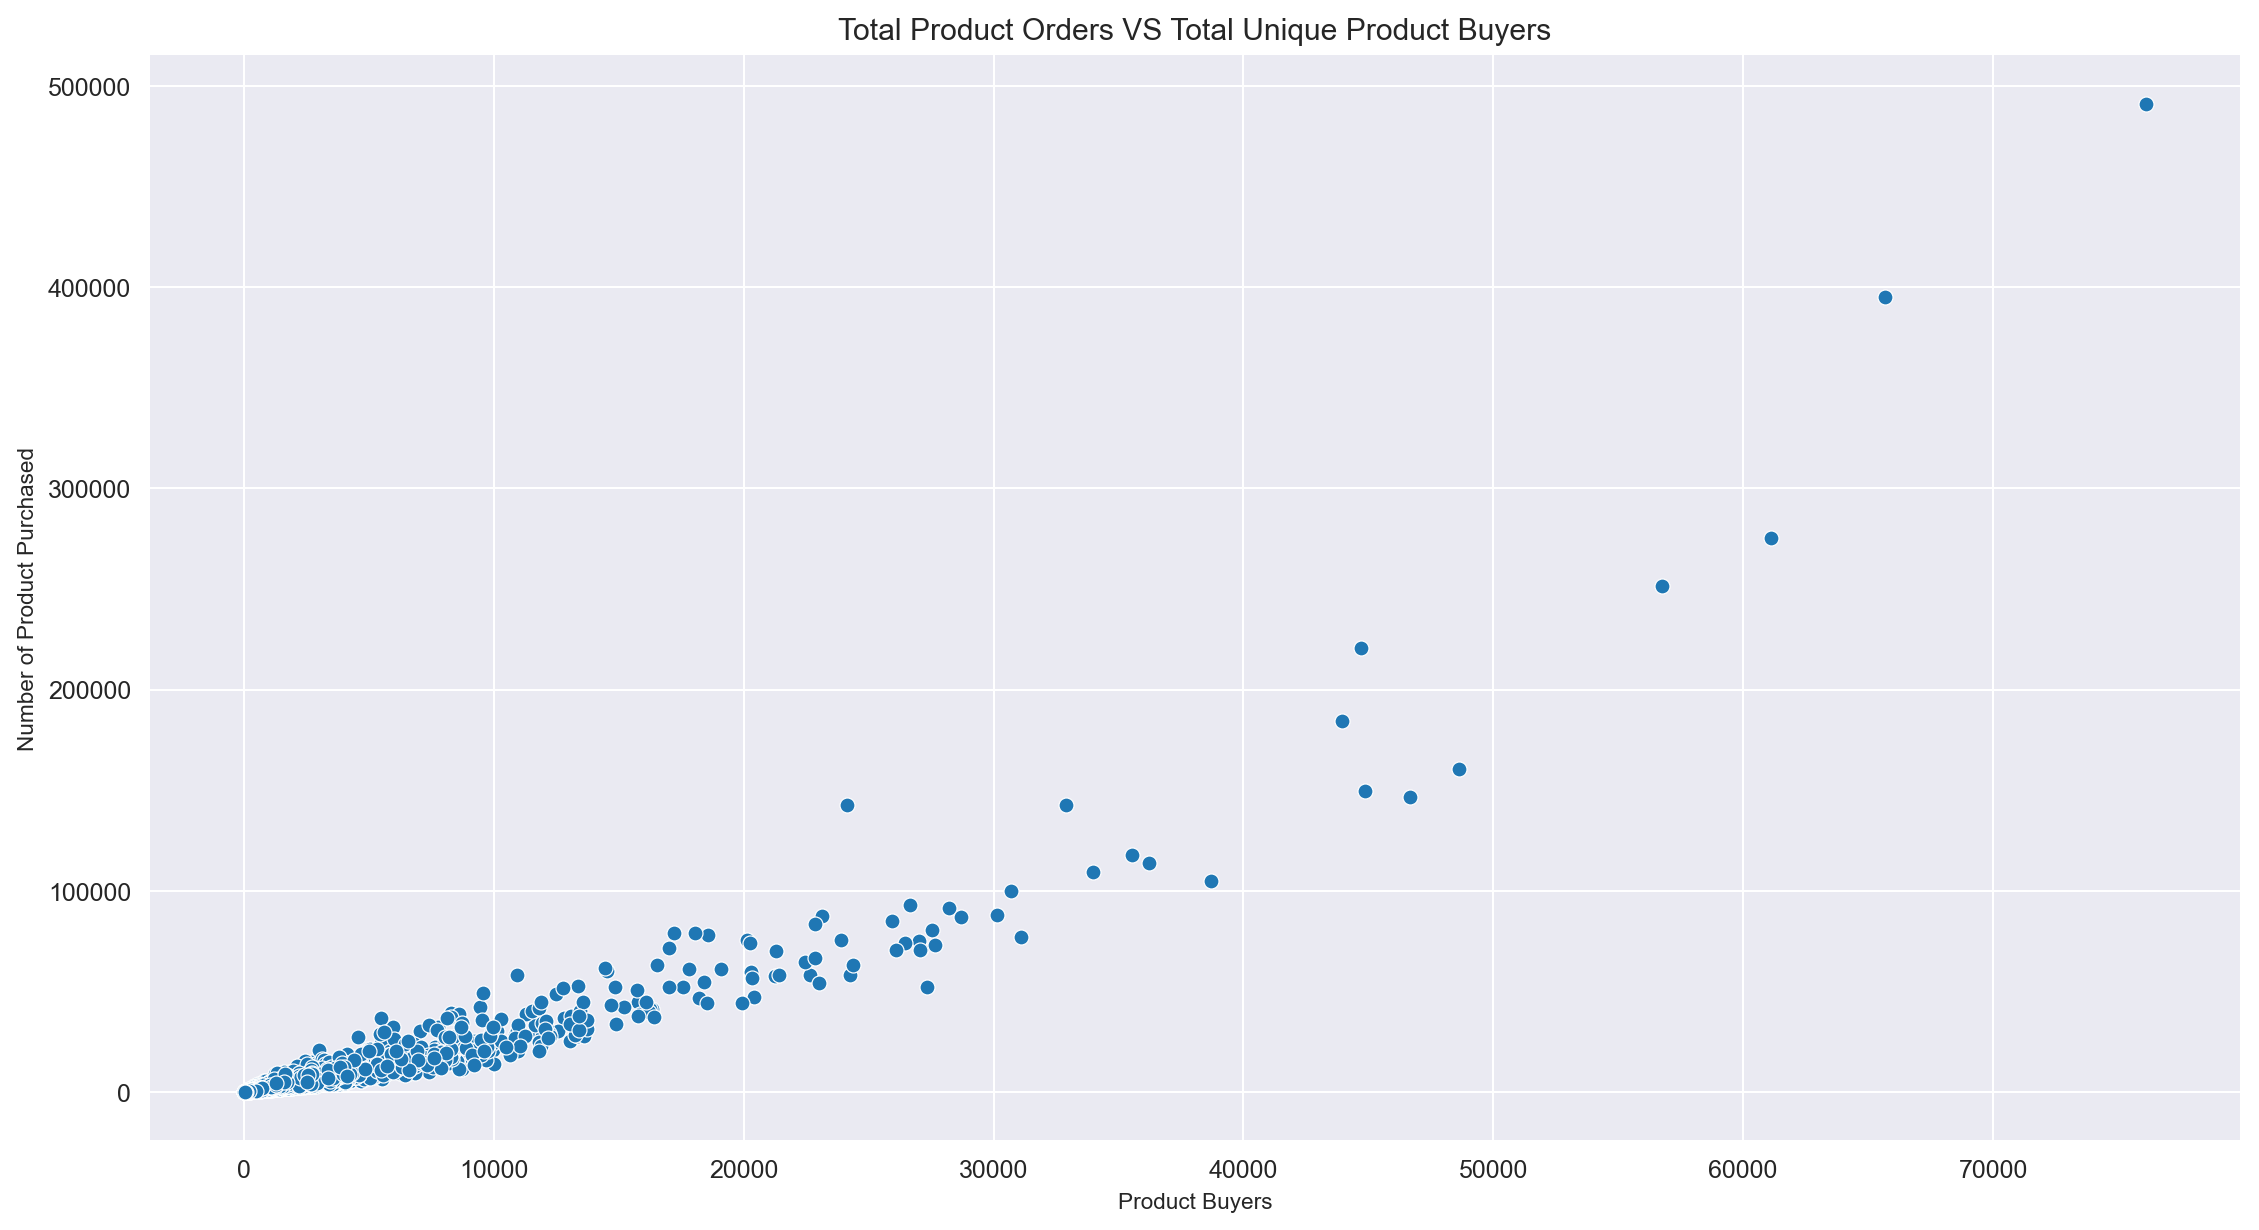

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.scatterplot(y = unique_product_users['total'], x = unique_product_users['total_users'])
ax.set_xlabel("Product Buyers", size = 9)
ax.set_ylabel("Number of Product Purchased", size = 9)
ax.set_title("Total Product Orders VS Total Unique Product Buyers", size = 12)
plt.show()

- A strong positive correlation exists between the total number of product ordered and the unique purchasing customers.

#### Reorder Percentage VS Total Orders

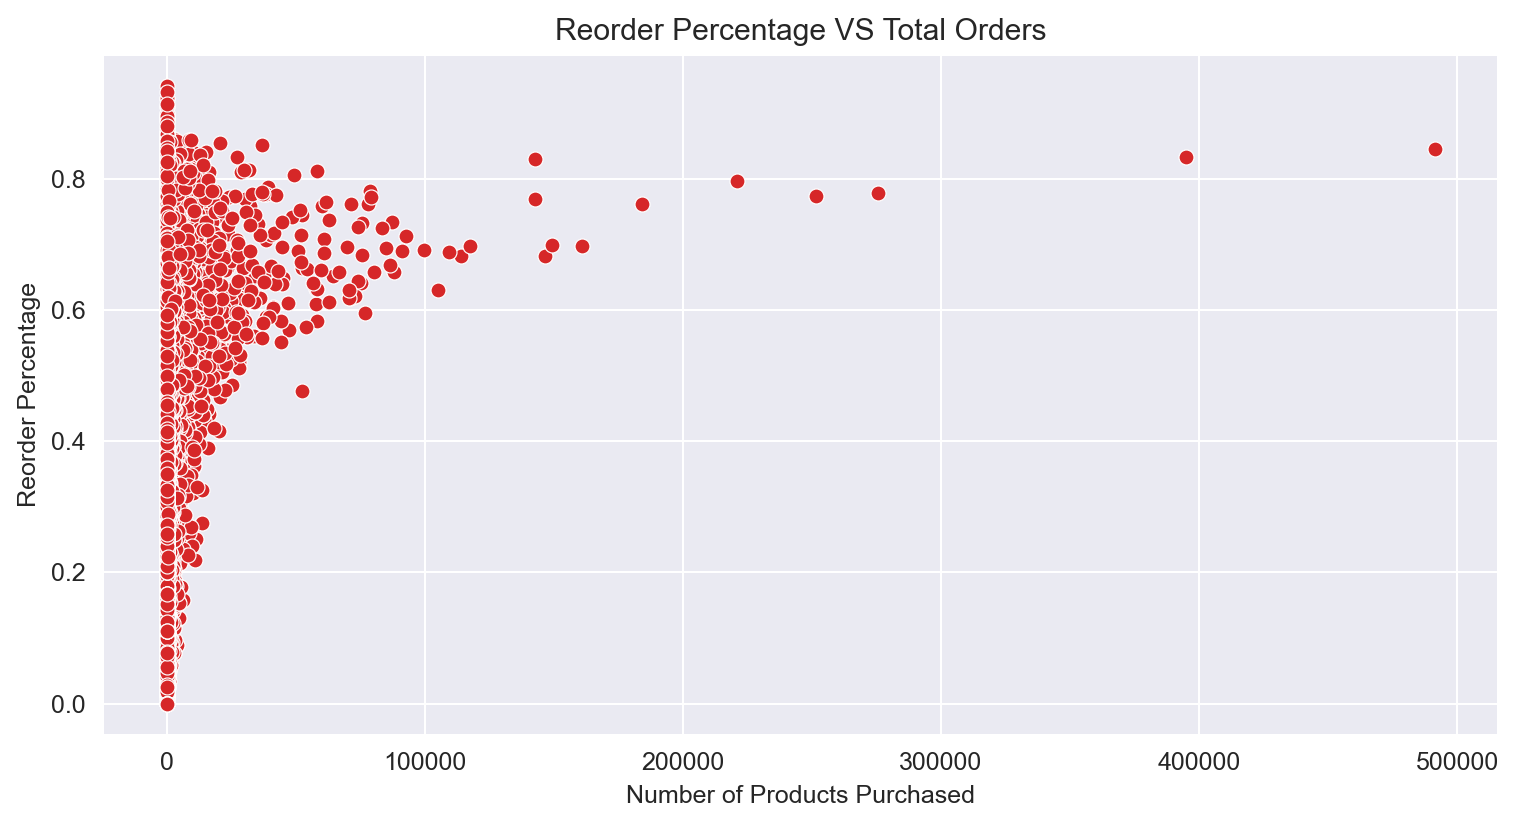

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = unique_product_users['total'], y = unique_product_users['ratio_of_reorder'], color = color[3])
ax.set_xlabel("Number of Products Purchased")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Orders")
plt.show()

- Weak positive correlation between reorder percentage and total number of product purchased.

#### Reorder Percentage VS Total Unique Users

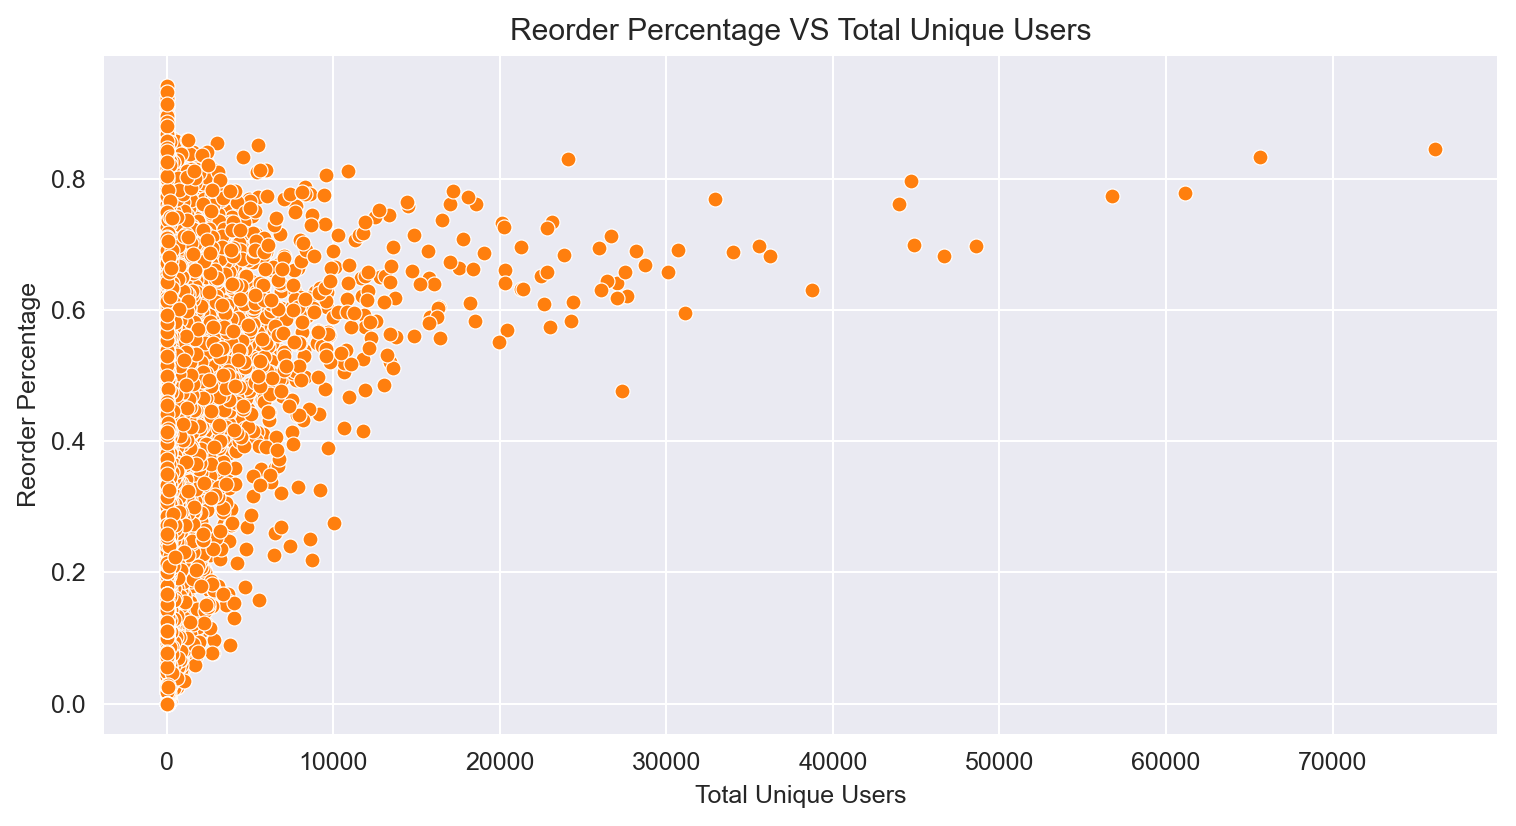

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(x = unique_product_users['total_users'], y = unique_product_users['ratio_of_reorder'], color = color[1])
ax.set_xlabel("Total Unique Users")
ax.set_ylabel("Reorder Percentage")
ax.set_title("Reorder Percentage VS Total Unique Users")
plt.show()

- Weak positive correlation between reorder percentage and total number of unique customers

#### Organic Vs Inorganic

In [27]:
unique_product_users['Organic'] = unique_product_users['product_name'].str.contains("Organic")
unique_product_users.head()

,product_name,total_users,total,reorders,ratio_of_reorder,Organic
0,#2 Coffee Filters,534,799,265.0,0.331665,False
1,#2 Cone White Coffee Filters,11,14,3.0,0.214286,False
2,#2 Mechanical Pencils,9,9,0.0,0.000000,False
3,#4 Natural Brown Coffee Filters,157,247,90.0,0.364372,False
4,& Go! Hazelnut Spread + Pretzel Sticks,81,174,93.0,0.534483,False


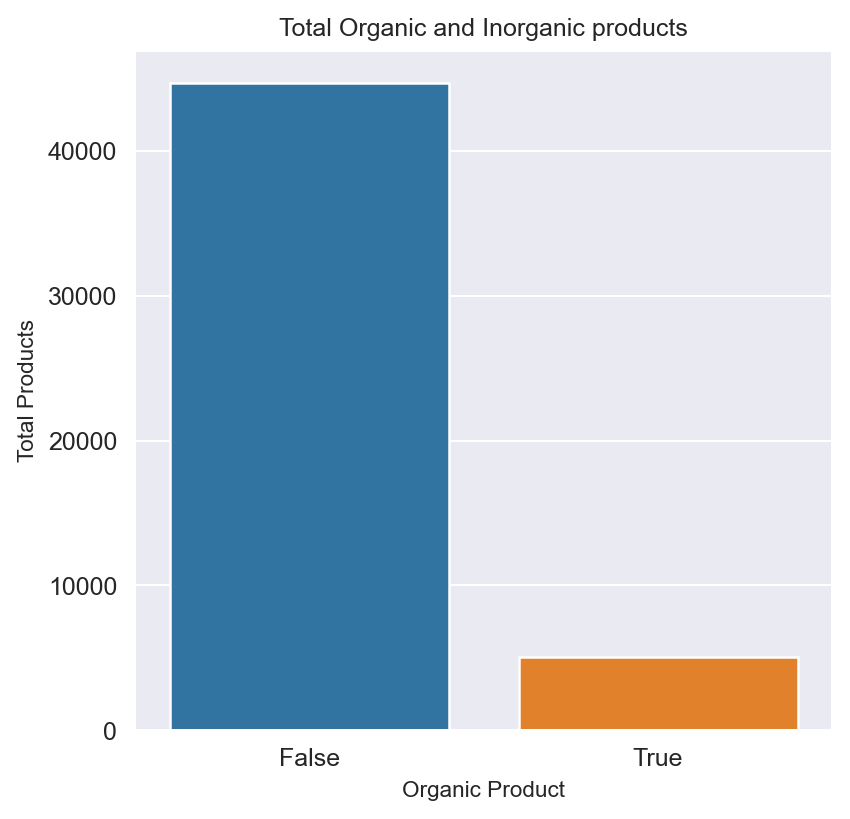

In [28]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = unique_product_users.groupby('Organic').size().index, y = unique_product_users.groupby('Organic').size().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Total Products", size = 9)
ax.set_title("Total Organic and Inorganic products", size = 10)
plt.show()

- There are more inorganic products than there are organic in the grocery store.

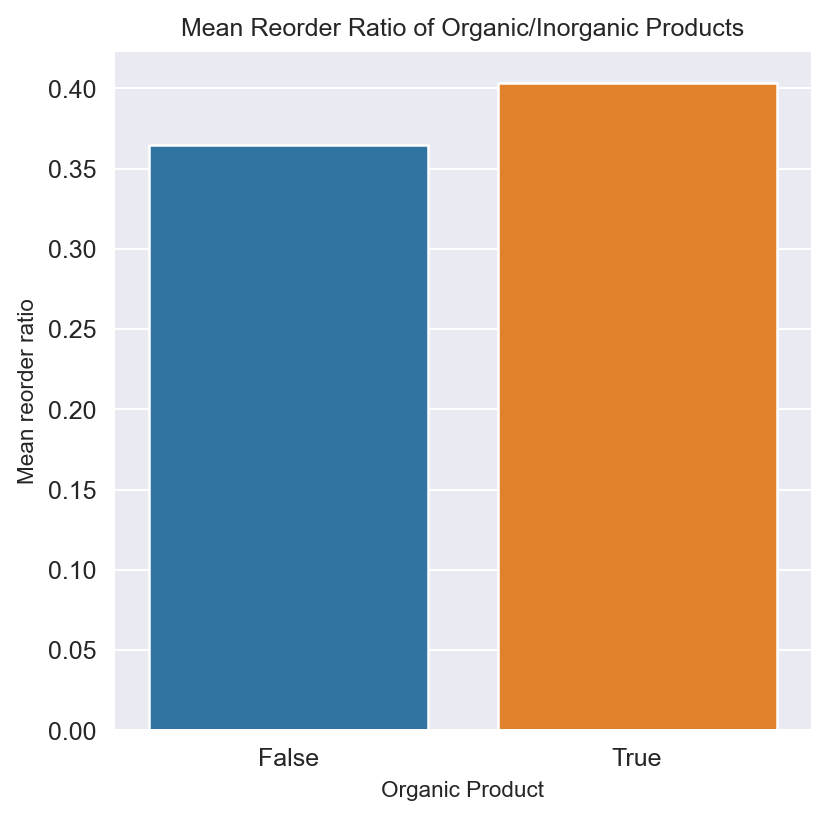

In [29]:
fig, ax = plt.subplots(figsize = (5,5))
ax = sns.barplot(x = unique_product_users.groupby('Organic')['ratio_of_reorder'].mean().index, y = unique_product_users.groupby('Organic')['ratio_of_reorder'].mean().values)
ax.set_xlabel("Organic Product", size = 9)
ax.set_ylabel("Mean reorder ratio", size = 9)
ax.set_title("Mean Reorder Ratio of Organic/Inorganic Products", size = 10)
plt.show()

- Generally, organic products have a higher reorder rate as compared to their inorganic counterparts. But only by a slight margin.
- There are no strong evidences to support high reorder rates using the organic content of grocery products.

#### Add to Cart Order VS Reorder  

In [30]:
cart_df = combined_order.groupby('add_to_cart_order')['reordered'].mean().reset_index()
cart_df.head()

,add_to_cart_order,reordered
0,1,0.679302
1,2,0.677135
2,3,0.658426
3,4,0.637350
4,5,0.617598


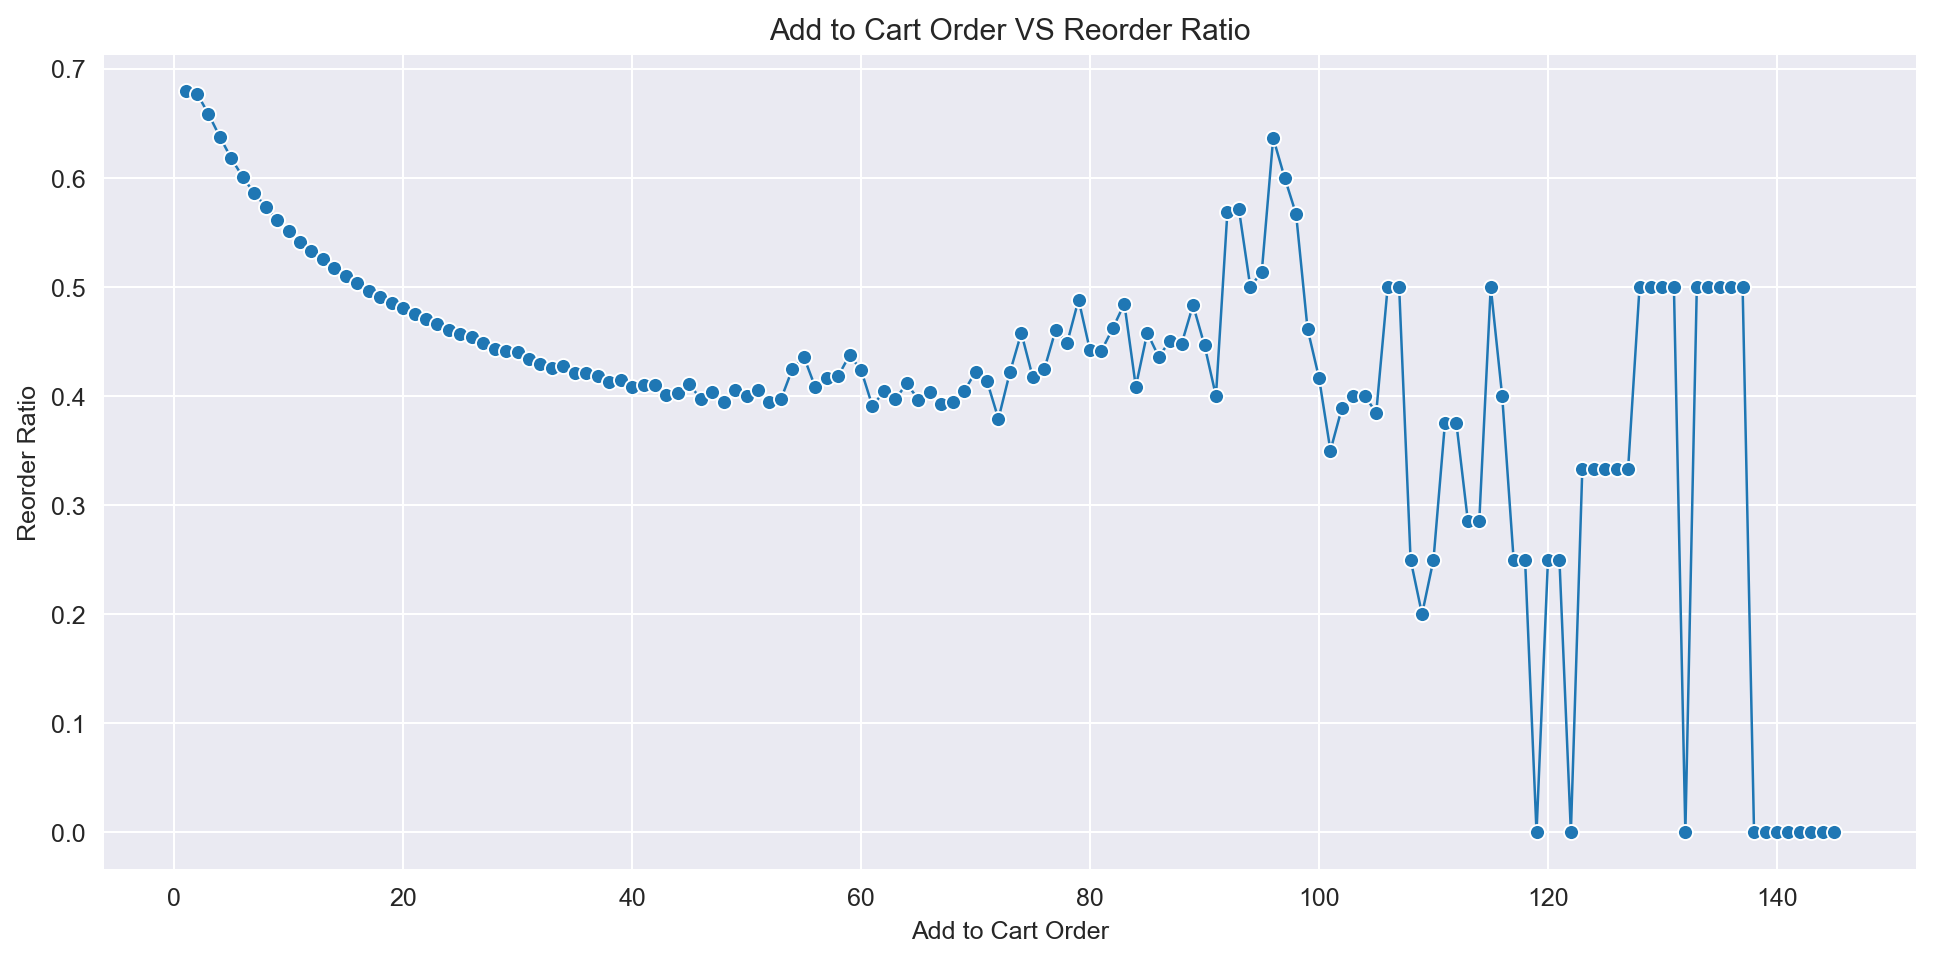

In [31]:
fig, ax = plt.subplots(figsize=(13,6))
ax = sns.lineplot(x=cart_df['add_to_cart_order'], y=cart_df['reordered'], lw = 1, marker='o')
ax.set_xlabel("Add to Cart Order")
ax.set_ylabel("Reorder Ratio")
ax.set_title("Add to Cart Order VS Reorder Ratio")
plt.show()

#### Most Popular Products on different days

In [32]:
popular_df = combined_order.groupby(['order_dow', 'product_name']).size().reset_index(name='counts')
popular_df = popular_df.sort_values(['order_dow', 'counts'], ascending=[True, False])
popular_df = popular_df.groupby('order_dow').head(5).reset_index(drop = True)

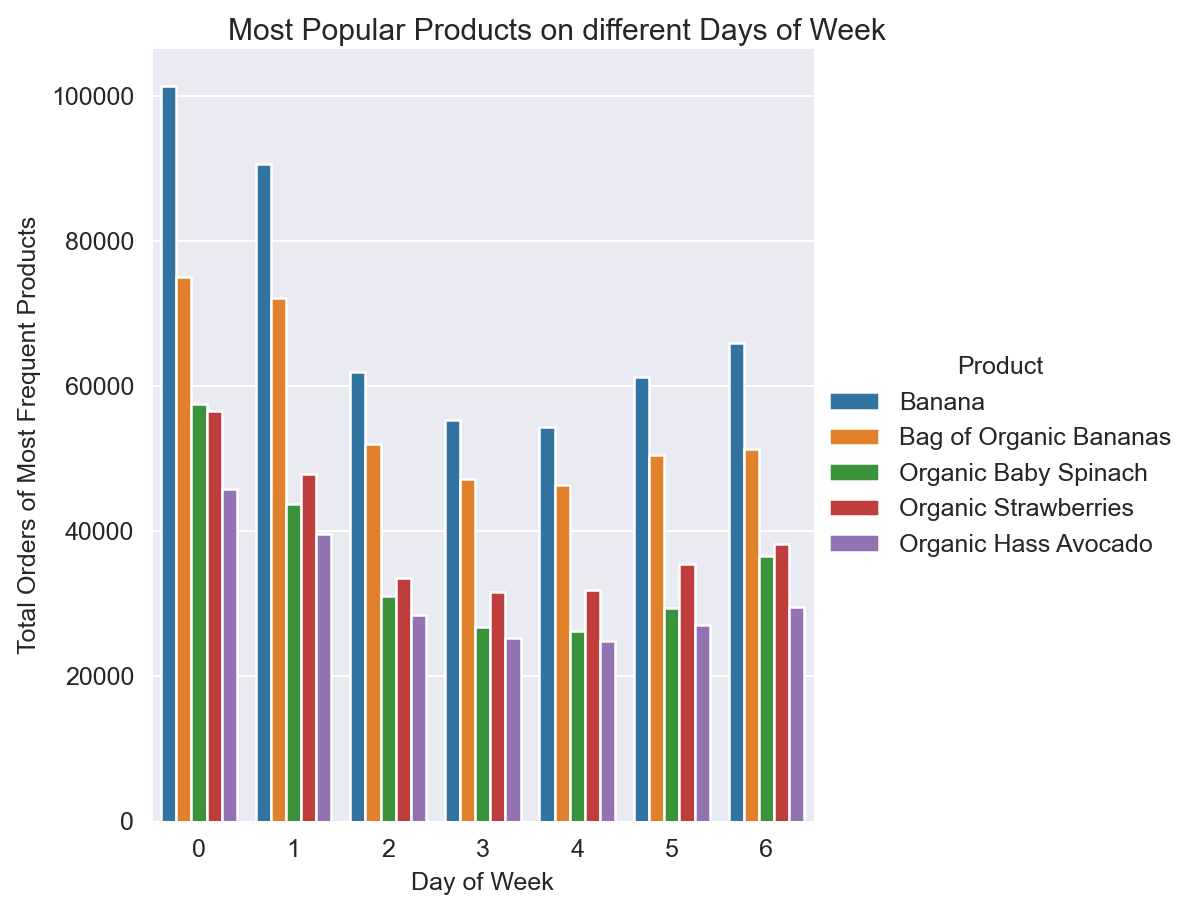

In [33]:
ax = sns.catplot(x="order_dow", y="counts", hue="product_name", data=popular_df, kind="bar", legend=False)
ax.add_legend(title="Product")
ax.set_axis_labels("Day of Week", "Total Orders of Most Frequent Products")
ax.fig.suptitle("Most Popular Products on different Days of Week", va="baseline", ha="center")
ax.savefig("Most Popular Products on Different Days of Week.png")

- Bananas and organic fruits are frequently ordered, with inorganic and organic bananas topping the spot every day.
- There are only more organic baby spinach ordered than strawberries on Saturdays.